# `eo-grow` Tutorial

The main objects in `eo-grow` package are structured like this

![eo-grow flowchart](../docs/source/figures/eo-grow-structure.png)

Let's take a close look in each of them

## Config

Most objects in `eo-grow` are configured with a `pydantic` model. The class of the configuration model is attached to the `eo-grow` object as a `Schema` class (e.g. `Pipeline.Schema`).

These configuration objects are great for parsing and validating, but the package also provides some utility functions/methods for working with dictionaries.
- `from_raw_config` creates the object from a dictionary, e.g. `Pipeline.from_raw_config(params_dict)`.
- `from_path` reads the configuration from a `.json` file and creates the appropriate object.


In [1]:
from eogrow.core.base import EOGrowObject


class TestObject(EOGrowObject):
    class Schema(EOGrowObject.Schema):
        test_param: int
        test_string: str = "default"


test_config = {"test_param": 3}
test_object = TestObject.from_raw_config(test_config)
test_object.config

Schema(test_param=3, test_string='default')

The package also offers utility in the form of a *config language*. It supports variables, combining of configs, relative paths and more.

The *interpretation* of this language is done automatically with `from_path`, but not in `from_raw_config`. One can also load an interpreted config dictionary with the function `interpret_config_from_path`. This dictionary can then be adjusted and passed to the appropriate object. 

In [2]:
import os

from eogrow.core.config import interpret_config_from_path

CONFIG_FOLDER = os.path.join("..", "tests", "test_config_files", "other")
CONFIG_FILE = os.path.join(CONFIG_FOLDER, "simple_config.json")

config = interpret_config_from_path(CONFIG_FILE)
config

{'pipeline': 'SimplePipeline',
 'test_param': 10,
 'test_subset': [0, 'eopatch-id-1-col-0-row-1'],
 'workers': 3,
 'logging': {'save_logs': True,
  'show_logs': True,
  'capture_warnings': True,
  'manager': 'eogrow.core.logging.LoggingManager'},
 'area': {'manager': 'eogrow.core.area.UtmZoneAreaManager',
  'area': {'filename': 'test_area.geojson', 'buffer': 0.001},
  'patch': {'size_x': 2400, 'size_y': 1100, 'buffer_x': 120, 'buffer_y': 55},
  'offset_x': 0,
  'offset_y': 0},
 'storage': {'manager': 'eogrow.core.storage.StorageManager',
  'project_folder': '/home/zluksic/Documents/Projects/eo-grow/tests/test_project',
  'structure': {'data': 'data',
   'batch_data': 'batch-data',
   'data_2019': 'data-2019',
   'data_custom_range': 'data-custom-range',
   'data_sampled': 'data-sampled',
   'features': 'features',
   'features_sampled': 'features-sampled',
   'training_data': 'training_data',
   'reference': 'reference',
   'models': 'models',
   'predictions': 'predictions',
   'predi

## StorageManager

Object in charge of folder structure of data. It contains a definition of entire folder structure

In [3]:
from eogrow.core.storage import StorageManager

storage = StorageManager.from_raw_config(config["storage"])

storage

The following folders are always defined in the folder structure

In [4]:
print(storage.get_input_data_folder())
print(storage.get_cache_folder())
print(storage.get_logs_folder())

input-data
cache
logs


Any other folder is custom defined

In [5]:
storage.get_folder("data", full_path=True)

'/home/zluksic/Documents/Projects/eo-grow/tests/test_project/data'

## AreaManager

The object in charge of splitting and managing area of interest (AOI)

In [6]:
from eogrow.core.area import UtmZoneAreaManager

area_manager = UtmZoneAreaManager.from_raw_config(config["area"], storage)

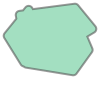

In [7]:
geometry = area_manager.get_area_geometry()

geometry.geometry

In [9]:
from sentinelhub import CRS

grid = area_manager.get_grid()
grid[CRS(32638)]

eopatch_name                                           geometry
0  eopatch-id-0-col-0-row-0  POLYGON ((729480.000 4390045.000, 729480.000 4...
1  eopatch-id-1-col-0-row-1  POLYGON ((729480.000 4391145.000, 729480.000 4...

In [10]:
area_manager.get_patch_list()

[('eopatch-id-0-col-0-row-0',
  BBox(((729480.0, 4390045.0), (732120.0, 4391255.0)), crs=CRS('32638'))),
 ('eopatch-id-1-col-0-row-1',
  BBox(((729480.0, 4391145.0), (732120.0, 4392355.0)), crs=CRS('32638')))]

## Pipeline

The main object in the package is `Pipeline`. It contains a schema for config parameters and a data-processing procedure.

In [11]:
from pydantic import Field

from eogrow.core.pipeline import Pipeline


class SimplePipeline(Pipeline):
    class Schema(Pipeline.Schema):
        test_param: int = Field(..., description="Some integer")

    def run_procedure(self):
        # implement something and return which EOPatches have been successfully processed and which not

        return [], []


pipeline = SimplePipeline.from_raw_config(config)

pipeline.run()

INFO eogrow.core.pipeline:225: Running SimplePipeline
INFO eogrow.core.pipeline:237: Pipeline finished successfully!
